# MiHATT4PdM – Quick start tutorial

This notebook shows the minimal working flow for use our proposed MiHATT4PdM

## 1. Exploring the time-series dataset

Assuming the datasets have been extracted in the `datasets` folder, we can choose any of the files of the turbofan or the bearing case study for this tutorial. For example, we can select the *FD001* dataset of the turbofan engine degradation problem.

If we load it as a Pandas Dataframe, we can see that the first column `unit` is the sequence identifier, while the second one is a step counter indicating the order in the sequence. The last column `HS` is the class label, and the intermediate columns are the sensor readings used to perform the machine learning.

In [1]:
from pathlib import Path
import pandas as pd

data_folder = Path('../datasets/turbofan_case_study')
data_key = 'FD001'

train_df = pd.read_csv(data_folder / f'{data_key}_train.csv')
test_df = pd.read_csv(data_folder / f'{data_key}_test.csv')
train_df

,unit,cycle,s1,s2,s3,s4,s5,s6,s7,s8,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,HS
0,1,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,1,2,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,1,3,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,1,4,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,1,5,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15485,100,196,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,2
15486,100,197,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,2
15487,100,198,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
15488,100,199,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,2


We can also check the useful information about data distribution, like the number of sequences belonging to each class or the length distribution of the time series.

In [2]:
import numpy as np

n_states = train_df.HS.unique()
train_count = dict()
test_count = dict()
for s in n_states:
    train_count[s] = len(train_df.query('cycle==1 and HS==@s'))
    test_count[s] = len(test_df.query('cycle==1 and HS==@s'))
print('Training sequences per class', train_count)
print('Testing sequences per class', test_count)

Training sequences per class {0: 32, 2: 33, 1: 34}
Testing sequences per class {0: 39, 2: 29, 1: 32}


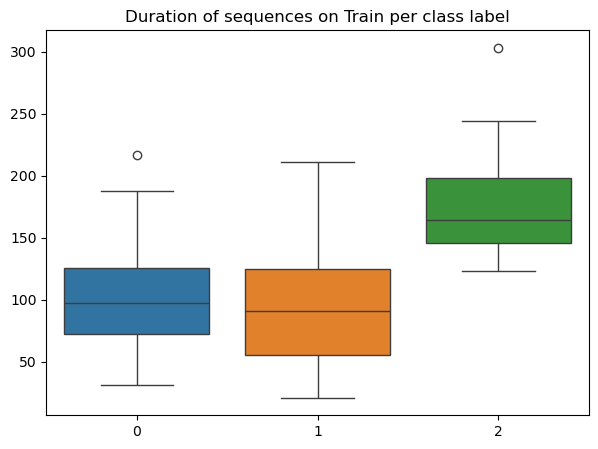

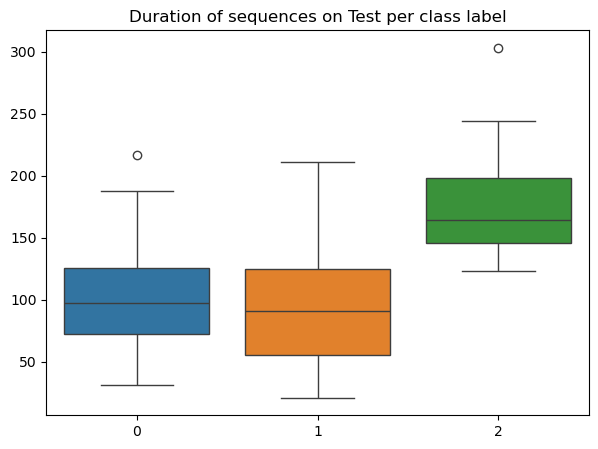

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train_len = dict()
test_len = dict()
for s in n_states:
    train_len[s] = train_df[train_df.HS==s].value_counts(subset=['unit']).to_numpy()
    test_len[s] = test_df[test_df.HS==s].value_counts(subset=['unit']).to_numpy()
train_len = dict(sorted(train_len.items()))
test_len = dict(sorted(test_len.items()))

plt.figure(figsize=(7, 5))
plt.title('Duration of sequences on Train per class label')
sns.boxplot(data=list(test_len.values()))
plt.show()

plt.figure(figsize=(7, 5))
plt.title('Duration of sequences on Test per class label')
sns.boxplot(data=list(test_len.values()))
plt.show()

### 1.1 Loading the dataset in the required format for the model

In order to work with these data in our proposal, we need to use an specific format consisting on a Pandas Multiindex Dataframe for the inputs, and a 1D array for the learning targets. The functions of the `utils` file provide this functionality:

In [1]:
from utils import load_CMAPSS

X_train, y_train = load_CMAPSS(key='FD001', split='train')
X_test, y_test = load_CMAPSS(key='FD001', split='test')

## 2. Defining the MiHATT model

To define the model, import the `MultiInstanceHATT` class and configure both the multi-instance parameters to create each bag of sub-sequences for each time series (instance length, stride between instances and number of relevant instances in each bag) and the Hoeffding Anytime Time parameters (number of instances to wait between split attempts, and tolerance for the Hoeffding bound).

In this case, we are going to split each sequence into instances of 21% of the average time series length, with a stride of 13% between them, and look for 2 consecutive instances for optimizing the concept of the time series. The grace period of the base tree will be 6.7% of the average time series length, and the tolerance of the Hoeffding bound, 0.0025.

In [2]:
from mihatt import MultiInstanceHATT

model = MultiInstanceHATT(inst_len=0.21, inst_stride=0.13, k=2, dependent_graceper=6.7, delta=0.0025)
model.ref_online_learner

ExtremelyFastDecisionTreeClassifier (
  grace_period=200
  max_depth=inf
  min_samples_reevaluate=20
  split_criterion="info_gain"
  delta=0.0025
  tau=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
  splitter=GaussianSplitter (
    n_splits=10
  )
  binary_split=False
  min_branch_fraction=0.01
  max_share_to_split=0.99
  max_size=100.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

## 3. Fitting the model to the training set

The `fit` method of the `MultiInstanceHATT` class carries out the training process of the model. Inside this function the time series are transformed to multi-instance bags, and afterwards the iterative growing of the tree takes place. This process begins with a first pass through all the instances. The following iterations look to refine the model with the most promising instances of the bag, that will be passed again to the incremental tree to make it expands. The iterative search finishes when `max_it` is reached or there are `max_patience` iterations without improving the accuracy in the training set.

The `fit` method requires the dataset to be in the format provided by the `load_CMAPSS` function explained in Section 1.1.

In [3]:
train_materials = model.fit(X_train, y_train)

The `fit` method returns a dictionary with the training evolution:

* `selection` are the instances composing the *concept* of each time series.
* `train_acc_hist` is the evolution of the accuracy on the training set across the iterations

In [5]:
train_materials.keys()

dict_keys(['selection', 'train_acc_hist'])

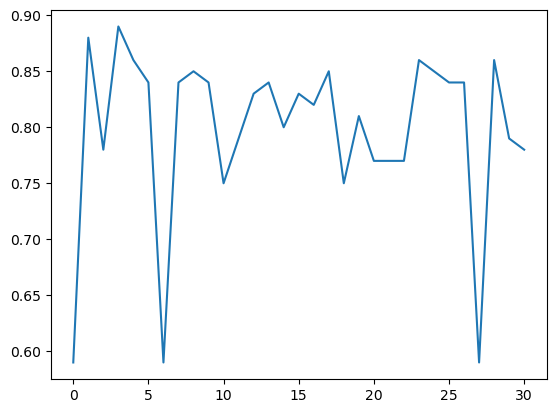

In [6]:
import matplotlib.pyplot as plt

plt.plot(train_materials['train_acc_hist'])

Once the model is fitted, we can use the `predict` method to get the estimated labels for the input time series. If we want to know the performance on the training set, we can use this output and any `scikit-learn.metrics` function to obtain any metric from the classification paradigm.

In [8]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)

print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        33
           1       0.83      0.85      0.84        34
           2       0.91      0.91      0.91        33

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



## 4. Testing the predictive performance with unknown data

In the same way we have evaluated the performance of the method over the training set, we can evaluate it over the test set using the method `predict` and the metric functions provided by the well-known library of `scikit-learn`

In [9]:
y_test_pred = model.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83        39
           1       0.65      0.69      0.67        32
           2       1.00      0.55      0.71        29

    accuracy                           0.75       100
   macro avg       0.80      0.73      0.74       100
weighted avg       0.79      0.75      0.74       100



## 5. Interpretative analysis of the solution

In order to complement the predictions provided by MIHATT, we can take advantage of its interpretative properties to get insights about the causes of that prediction.

On the one hand, we can access to the base tree generated after training the model accessing to the object `online_learner`. Functions of it such as `draw()` or `to_dataframe()` allow us to explore the tree structure and get to know the most relevant input attributes and the probability of each class at any leaf node.

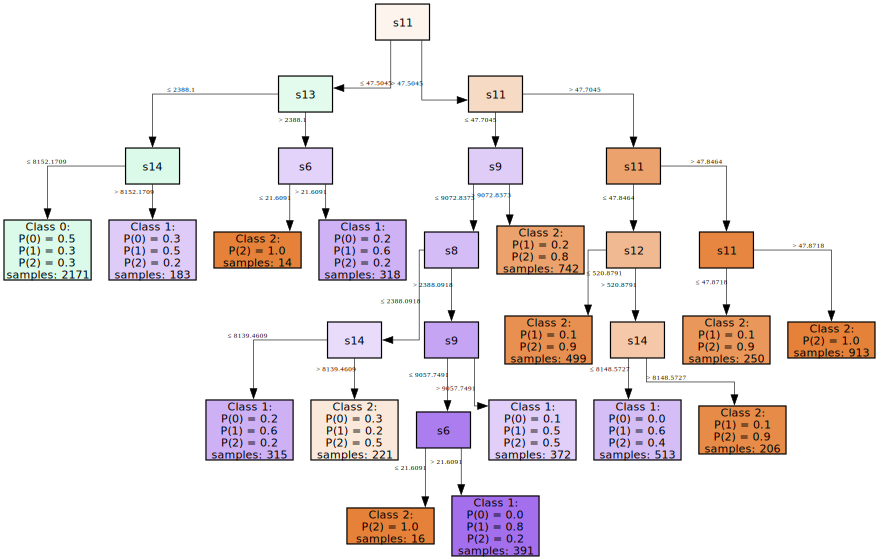

In [10]:
model.online_learner.draw()

In [11]:
model.online_learner.to_dataframe()

,parent,is_leaf,depth,stats,feature,threshold,splitter,splitters,_disabled_attrs,_last_split_reevaluation_at,_last_split_attempt_at,_mc_correct_weight,_nb_correct_weight
node,,,,,,,,,,,,,
0,<NA>,False,0,"{0: 9174.0, 2: 12903.0, 1: 11055.0}",s11,47.504545,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},33131.000000,NaN,NaN,NaN
1,0,False,1,"{0: 8201.82635678556, 2: 5433.575545721559, 1:...",s13,2388.100000,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},19051.943228,NaN,NaN,NaN
2,0,False,1,"{0: 972.1736432144403, 2: 7469.424454278441, 1...",s11,47.704545,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},14074.056772,NaN,NaN,NaN
3,1,False,2,"{1: 4029.480662449567, 2: 3869.778672990196, 0...",s14,8152.170909,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},14352.349986,NaN,NaN,NaN
4,1,False,2,"{1: 1119.5193375504332, 2: 802.2213270098041, ...",s6,21.609091,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},2205.650014,NaN,NaN,NaN
5,2,False,2,"{1: 3692.1838905556756, 2: 3070.9014689046767,...",s9,9072.837273,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},7341.360580,NaN,NaN,NaN
6,2,False,2,"{1: 574.8161094443244, 2: 2784.0985310953233, ...",s11,47.846364,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},3350.639420,NaN,NaN,NaN
7,3,True,3,"{1: 559.5216374446329, 0: 981.217157340129, 2:...",NaN,NaN,GaussianSplitter,"{'s1': GaussianSplitter, 's2': GaussianSplitte...",{},NaN,2161.422248,10.0,2.0
8,3,True,3,"{1: 93.47836255536708, 0: 47.782842659870994, ...",NaN,NaN,GaussianSplitter,{},{},NaN,183.577752,0.0,0.0


On the other hand, we can visualize the most relevant subsequence of each time series employing the k consecutive instances that maximize the likelihood of the predicted class. To this aim, we use the method `predict_signature` of the `MultiInstanceHATT` class together with the test dataset. This method returns information of when the estimated signature of the series starts, that can be plot together with the original time series.

In [30]:
y_test_pred, best_inst = model.predict_signature(X_test)

Sequence 9: real class: 0, predicted class: 0.0, k: 2


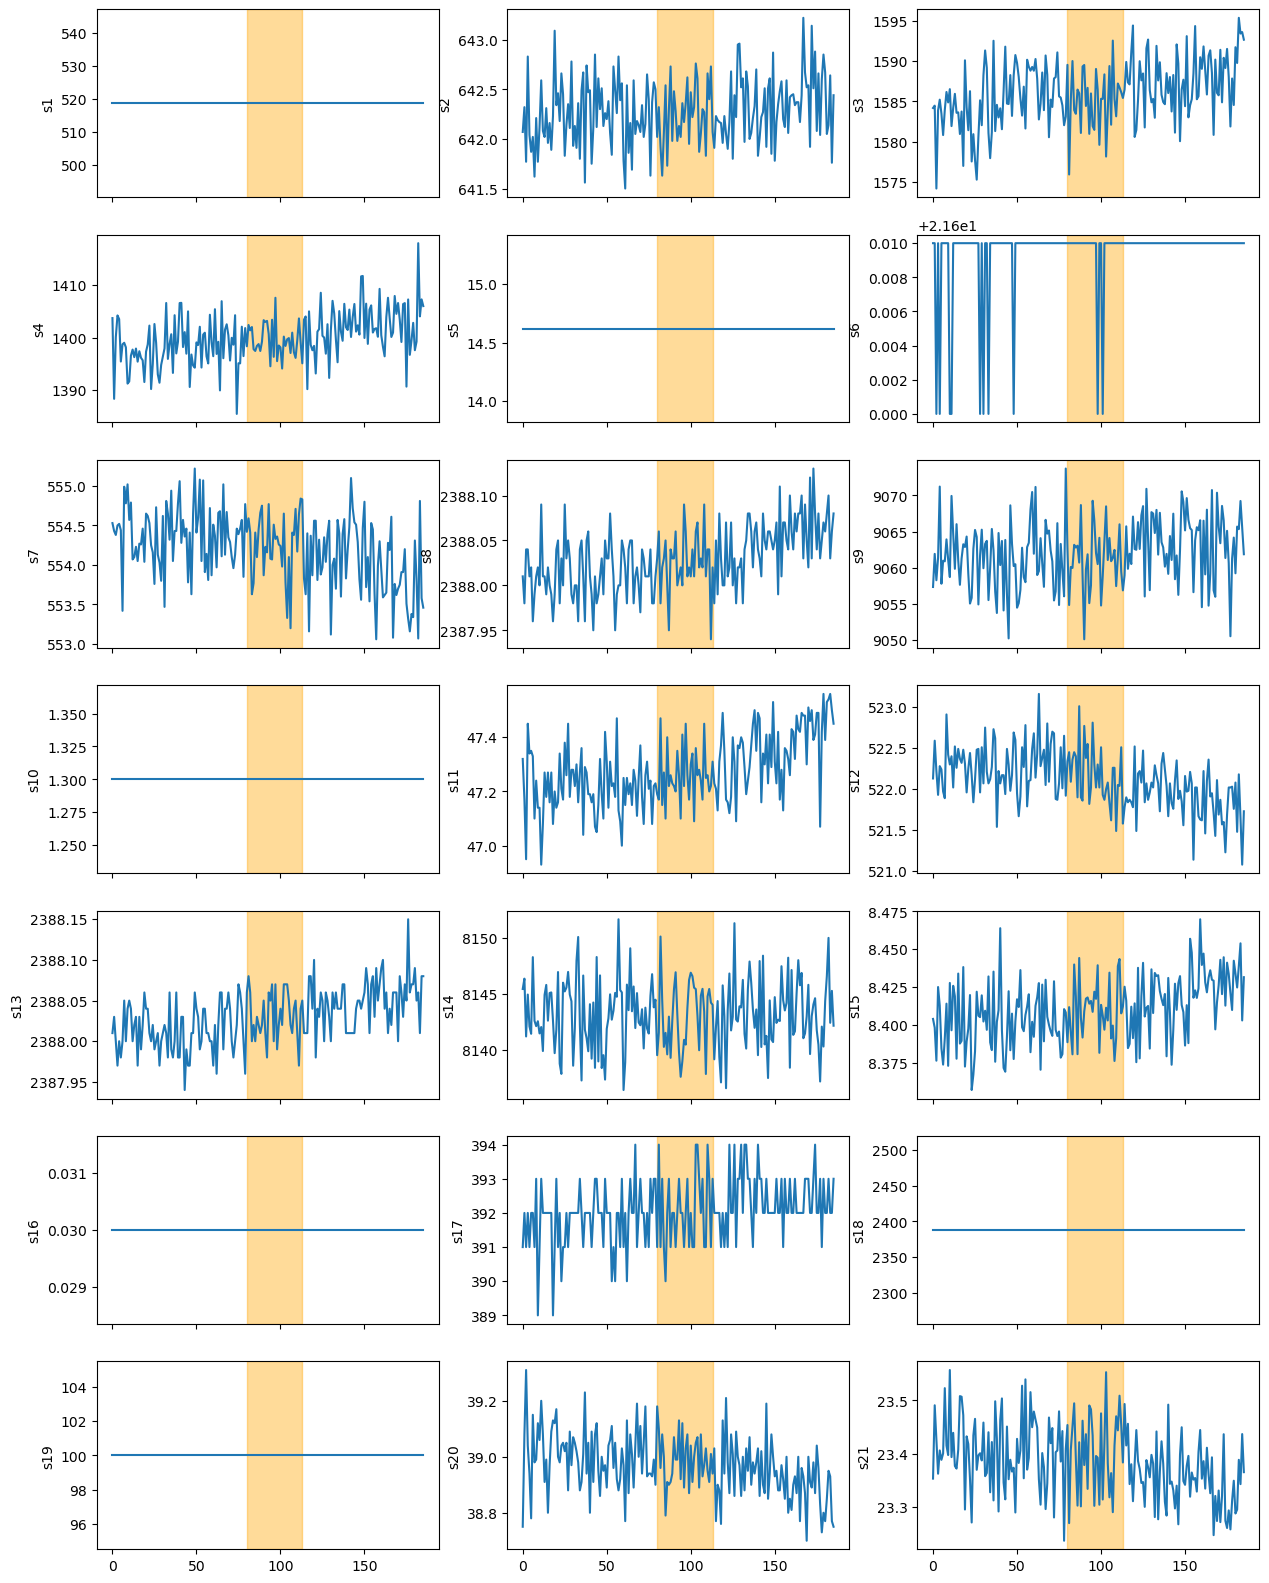

In [28]:
columns = [f's{i}' for i in range(1,22)]
for i, seq in X_test.groupby(level=0):
    if i != 9:
        continue
    print(f'Sequence {i}: real class: {y_test[i]}, predicted class: {y_test_pred[i]}, k: {best_inst[i][1]}')
    fig, ax = plt.subplots(7, 3, sharex='all', figsize=(15, 20))
    for c, ax_i in zip(columns, ax.reshape(-1)):
        ax_i.plot([t[1] for t in seq.index], seq[c])
        ax_i.axvspan(best_inst[i][4][0], best_inst[i][5][0], alpha=.4, color='orange')
        ax_i.set_ylabel(c)
    plt.show()
    plt.close()
